In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt

In [87]:
def preprocess(df, target_col='target'):
    X = df.drop(target_col, axis=1).copy()
    y = df[[target_col]].copy()
    return X, y


def train(X, y, test_size, random_state=42, model_constructor=LinearRegression, **model_args):
    model = model_constructor(**model_args)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test


def evaluate(model, X_train, X_test, y_train, y_test, metrics=[f1_score, accuracy_score, precision_score, recall_score]):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    score_train, score_test = {}, {}

    if isinstance(metrics, list):
        for metric in metrics:
            score_train[metric.__name__] = metric(y_train, np.clip(y_pred_train.round(), 0, 1))
            score_test[metric.__name__] = metric(y_test, np.clip(y_pred_test.round(), 0, 1))
    else:
        score_train[metric.__name__] = metric(y_train, y_pred_train.round())
        score_test[metric.__name__] = metric(y_test, y_pred_test.round())


    return score_train, score_test


def optimize(df, test_size, model_constructor, param_list, plot=True, eval_metric='f1_score'):
    X, y = preprocess(df)
    out_data = []

    out_model = None     
    top_test_score = 0   
    
    for params in param_list:
        model, *split_data = train(X, y, test_size=test_size, model_constructor=model_constructor, **params)
        train_score, test_score = evaluate(model, *split_data)
        out_data.append({'params': params, 'train_score': train_score, 'test_score': test_score})

        if test_score[eval_metric] > top_test_score:
            out_model = model
            top_test_score = test_score[eval_metric]
            best_params = params
            best_score = test_score
    
    if plot:
        plt.figure()
        plt.title(eval_metric)
        xlabels = [str(x['params'])+'\n' for x in out_data]
        plt.plot(xlabels, [x['train_score'][eval_metric] for x in out_data])
        plt.plot(xlabels, [x['test_score'][eval_metric] for x in out_data])
        plt.legend(['Train', 'Test'])
        plt.xticks(rotation=90)
        plt.grid('on')
        plt.show()

    return out_model, out_data, best_score, best_params

In [88]:
df = pd.read_csv('data/processed/clean_and_filled.csv')

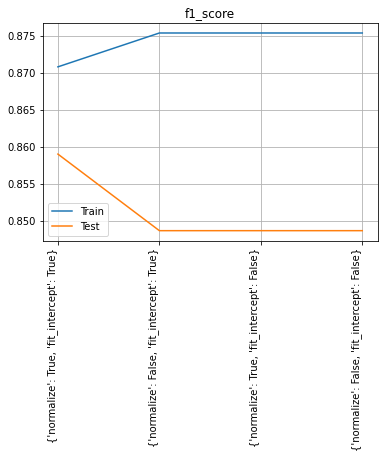

{'f1_score': 0.8590163934426229, 'accuracy_score': 0.8407407407407408, 'precision_score': 0.8291139240506329, 'recall_score': 0.891156462585034}
{'normalize': True, 'fit_intercept': True}


In [89]:
test_size = 0.3
linear_model, linear_res, linear_best_score, linear_best_params = optimize(df, test_size, model_constructor=LinearRegression, param_list=[{'normalize': True, 'fit_intercept': True},
                                                {'normalize': False, 'fit_intercept': True},
                                                {'normalize': True, 'fit_intercept': False},
                                                {'normalize': False, 'fit_intercept': False}])

print(linear_best_score)
print(linear_best_params)

<ipython-input-87-42af9cd1d075>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-87-42af9cd1d075>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-87-42af9cd1d075>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-87-42af9cd1d075>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-87-42af9cd1d075>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected

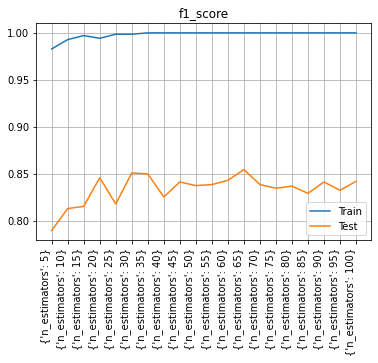

{'f1_score': 0.8543046357615893, 'accuracy_score': 0.837037037037037, 'precision_score': 0.832258064516129, 'recall_score': 0.8775510204081632}
{'n_estimators': 65}


In [90]:
rf_model, rf_result, rf_best_score, rf_best_params = optimize(df, test_size, model_constructor=RandomForestClassifier, param_list=[{'n_estimators': x} for x in np.arange(5, 101, 5)])

print(rf_best_score)
print(rf_best_params)

d:\Code\udacity\ds_capstone_1-Blog_post\heart_attack_analysis\.venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
d:\Code\udacity\ds_capstone_1-Blog_post\heart_attack_analysis\.venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
d:\Code\udacity\ds_capstone_1-Blog_post\heart_attack_analysis\.venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
d:\Code\udacity\ds_capstone_1-Blog_post\heart_attack_analysis\.venv\lib\site-packages\sklearn\

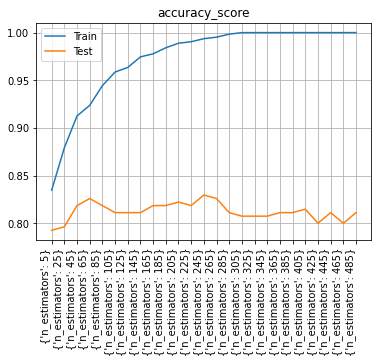

{'f1_score': 0.8486842105263158, 'accuracy_score': 0.8296296296296296, 'precision_score': 0.821656050955414, 'recall_score': 0.8775510204081632} {'n_estimators': 245}


Text(0.5, 1.0, 'Model Scores Comparison (test only)')

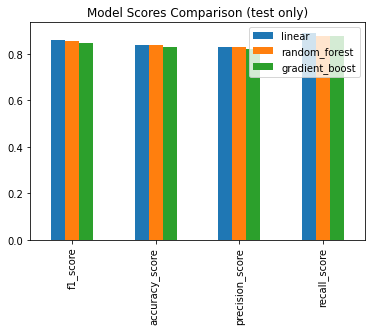

In [91]:
gb_model, gb_result, gb_best_score, gb_best_params = optimize(df, test_size, model_constructor=GradientBoostingClassifier, param_list=[{'n_estimators': x} for x in np.arange(5, 500, 20)], eval_metric='accuracy_score')
print(gb_best_score, gb_best_params)
pd.DataFrame([linear_best_score, rf_best_score, gb_best_score], index=['linear', 'random_forest', 'gradient_boost']).T.plot.bar()
plt.title('Model Scores Comparison (test only)')

In [145]:
imp_df = pd.DataFrame(index=df.drop('target', axis=1).columns, data=zip(rf_model.feature_importances_, gb_model.feature_importances_, linear_model.coef_.reshape(-1)), columns=['rf_importance', 'gb_importance', 'linear_coef'])

In [148]:
imp_df.sort_values('rf_importance', ascending=False)

,rf_importance,gb_importance,linear_coef
cp_type_no_pain,0.078098,0.245945,-2.476609e+12
st_dep,0.068937,0.058141,9.221014e-02
heart_rate_peak,0.066704,0.034540,-1.531536e-03
chol,0.054130,0.071374,-3.745189e-05
age,0.052895,0.060347,1.966628e-03
ex_duration,0.037847,0.032037,8.028795e-03
ex_angina,0.037763,0.026208,1.088550e-01
vessels_colored,0.035734,0.074065,1.348294e-01
heart_rate_rest,0.032989,0.028710,1.192663e-04
met,0.032803,0.051086,-9.831136e-04
